In [578]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot

In [588]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrainRaw, labelTrainRaw), (imageTestRaw, labelTestRaw) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTestRaw = imageTestRaw[:]
labelTestRaw = labelTestRaw[:]

imageValidRaw = imageTrainRaw[55000:]
labelValidRaw = labelTrainRaw[55000:]

imageTrainRaw = imageTrainRaw[:55000]
labelTrainRaw = labelTrainRaw[:55000]

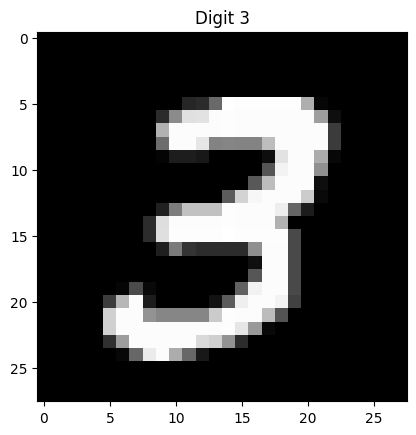

In [589]:
# Visualizing data
# Printing an array
def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrainRaw[idx][i][j])) == 1):
                to_write += str(imageTrainRaw[idx][i][j]) + "    "
            elif(len(str(imageTrainRaw[idx][i][j])) == 2):
                to_write += str(imageTrainRaw[idx][i][j]) + "   "
            else:
                to_write += str(imageTrainRaw[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrainRaw[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)
        
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrainRaw[idx]}")
    pyplot.imshow(imageTrainRaw[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")

idx = 7
printArr(idx)
plotImage(idx)

In [581]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
imageTest = imageTestRaw / 255
labelTest = tf.keras.utils.to_categorical(labelTestRaw, num_classes=10)

imageValid = imageValidRaw / 255
labelValid = tf.keras.utils.to_categorical(labelValidRaw, num_classes=10)

imageTrain = imageTrainRaw / 255
labelTrain = tf.keras.utils.to_categorical(labelTrainRaw, num_classes=10)

In [582]:
# Setting up the neural network layer dimension and hypermeters 
batchSize = 50      # Batch size to perform GD
iter = 20000        # Number of iterations
eta = 0.05          # Initial learning rate
stride = 1          # Stride for convolution layer
padding = 0         # Padding for convolution layer
inputDim = 28       # Dimension of input layer = 28 x 28
kernelNum = 1       # Number of kernels (filters)
kernelDim = 3       # Dimension of kernel = 3 x 3
featureDim = 26     # Dimension of feature map = inputDim + 2 * padding - kernelDim) / stride + 1 
hiddenDim = 20      # Dimension of hidden layer = 20 x 20
outputDim = 10      # Dimension of output layer = 10 x 1

In [583]:
def convolution(x, k):
    result = np.zeros((kernelNum, featureDim, featureDim))
    
    for n in range(kernelNum):
        for i in range(featureDim):
            for j in range(featureDim):
                result[n, i, j] = np.sum(np.multiply(k[n], x[i : i + kernelDim, j : j + kernelDim]))
    return result

# ReLU activation for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax activation for output layer
def softmax(x):
    c = np.max(x, axis = 0, keepdims=True)
    x -= c
    e = np.exp(x)
    return e / np.sum(e, axis = 0, keepdims=True)

# Calculating loss value using cross entropy
def lossCE(yCal, yLabel):
    result = -np.sum(np.log(yCal) * yLabel)
    return result

def train(batchSize, iter, eta, filename):
    # Initializing kernels, weights, biases and eta
    k =  0.01 * np.random.rand(kernelNum, kernelDim, kernelDim)
    w1 = 0.01 * np.random.rand(kernelNum * featureDim**2, hiddenDim**2)
    b1 = 0.01 * np.random.rand(hiddenDim**2, 1)
    w2 = 0.01 * np.random.rand(hiddenDim**2, outputDim)
    b2 = 0.01 * np.random.rand(outputDim, 1)

    
    lossList = []
    lossEpoch = 5
    lossPrev = 1000
    to_write = ""
    
    for n in range(iter + 1):
        if(n % 100 == 0):
            print(f"[Iter {n}]")
            lossList.append(lossEpoch / batchSize)
            
        idxList = np.random.randint(low=0, high=55000, size=batchSize) 
        lossEpoch = 0
        
        for idx in idxList:
            # Feedforward
            x = imageTrain[idx]
            v = convolution(x, k).reshape(kernelNum * featureDim**2, 1)
            z1 = np.dot(w1.T, v) + b1
            a1 = relu(z1)
            z2 = np.dot(w2.T, a1) + b2
            a2 = softmax(z2)
        
            yCal = a2
            yLabel = labelTrain[idx].reshape(10, 1)
            loss = lossCE(yCal, yLabel)
            lossEpoch += loss
            if(loss < lossPrev):
                lossPrev = loss
                kRes = k
                w1Res = w1
                b1Res = b1
                w2Res = w2
                b2Res = b2
                print(f"[Iter {n}] Loss: {loss}")
                to_write += f"[Iter {n}] Loss: {loss}\n"
                
            # Backpropagation
            e2 = yCal - yLabel # gradient of softmax using cross entropy
            dw2 = np.dot(a1, e2.T)
            db2 = e2
            e1 = np.dot(w2, e2)
            e1[z1 <= 0] = 0 # gradient of ReLU
            dw1 = np.dot(v, e1.T)
            db1 = e1

            # Updating weights and biases
            w1 += -eta * dw1
            b1 += -eta * db1
            w2 += -eta * dw2
            b2 += -eta * db2
    
    with open(f"./test/{filename}.txt", "w") as file:
        file.write(to_write)
        
    return (kRes, w1Res, b1Res, w2Res, b2Res, lossList)


In [591]:
def checkValid(kRes, w1Res, b1Res, w2Res, b2Res):
    count = 0
    for idx in range(5000):
        if(idx % 100 == 0 or idx == 4999):
            print(f"Image: {idx}")
        x = imageValid[idx]
        v = convolution(x, kRes).reshape(1, kernelNum * featureDim**2)
        z1 = np.dot(w1Res.T, v.T) + b1Res
        a1 = relu(z1)
        z2 = np.dot(w2Res.T, a1) + b2Res
        a2 = softmax(z2)
        yCal = a2
        yLabel = labelValid[idx].reshape(10, 1)
        prediction = np.argmax(yCal, axis=0)
        answer = np.argmax(yLabel, axis=0)
        if(prediction == answer):
            count += 1
    return count / 5000

def checkTest(kRes, w1Res, b1Res, w2Res, b2Res):
    count = 0
    for idx in range(10000):
        if(idx % 100 == 0 or idx == 9999):
            print(f"Image: {idx}")
        x = imageTest[idx]
        v = convolution(x, kRes).reshape(1, kernelNum * featureDim**2)
        z1 = np.dot(w1Res.T, v.T) + b1Res
        a1 = relu(z1)
        z2 = np.dot(w2Res.T, a1) + b2Res
        a2 = softmax(z2)
        yCal = a2
        yLabel = labelTest[idx].reshape(10, 1)
        prediction = np.argmax(yCal, axis=0)
        answer = np.argmax(yLabel, axis=0)
        if(prediction == answer):
            count += 1
    return count / 10000

In [585]:
(mini_kRes, mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, miniLoss) = train(batchSize=1, iter=100000, eta=0.05, filename="miniLoss")

[Iter 0]
[Iter 0] Loss: 2.3003172134770646
[Iter 2] Loss: 2.235486843961148
[Iter 9] Loss: 2.204023008659503
[Iter 18] Loss: 2.194129845556492
[Iter 23] Loss: 2.17634025632191
[Iter 25] Loss: 2.0989857148774353
[Iter 30] Loss: 2.047101725618289
[Iter 56] Loss: 2.0286020843703847
[Iter 60] Loss: 1.983444598330637
[Iter 66] Loss: 1.972960340551427
[Iter 73] Loss: 1.9601306475089664
[Iter 100]
[Iter 200]
[Iter 300]
[Iter 400]
[Iter 444] Loss: 1.960087828829347
[Iter 500]
[Iter 524] Loss: 1.9224703806861614
[Iter 600]
[Iter 700]
[Iter 800]
[Iter 875] Loss: 1.8246619909162043
[Iter 883] Loss: 1.693435346825172
[Iter 900]
[Iter 1000]
[Iter 1040] Loss: 1.5943486336676038
[Iter 1094] Loss: 1.4042935873495217
[Iter 1100]
[Iter 1200]
[Iter 1240] Loss: 1.26596782153989
[Iter 1255] Loss: 1.1495173536766077
[Iter 1300]
[Iter 1369] Loss: 0.7701230892563117
[Iter 1400]
[Iter 1500]
[Iter 1531] Loss: 0.6469037277098613
[Iter 1600]
[Iter 1700]
[Iter 1709] Loss: 0.29379415756000415
[Iter 1800]
[Iter 1900

In [594]:
resultValid = checkValid(mini_kRes, mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res)
print(f"Prediction correctness: {resultValid * 100}%")
with open("./test/resultValid.txt", "w") as file:
    file.write(f"Prediction correctness: {resultValid * 100}%")
# pyplot.plot(miniLoss)
# pyplot.show() 

Image: 0
Image: 100
Image: 200
Image: 300
Image: 400
Image: 500
Image: 600
Image: 700
Image: 800
Image: 900
Image: 1000
Image: 1100
Image: 1200
Image: 1300
Image: 1400
Image: 1500
Image: 1600
Image: 1700
Image: 1800
Image: 1900
Image: 2000
Image: 2100
Image: 2200
Image: 2300
Image: 2400
Image: 2500
Image: 2600
Image: 2700
Image: 2800
Image: 2900
Image: 3000
Image: 3100
Image: 3200
Image: 3300
Image: 3400
Image: 3500
Image: 3600
Image: 3700
Image: 3800
Image: 3900
Image: 4000
Image: 4100
Image: 4200
Image: 4300
Image: 4400
Image: 4500
Image: 4600
Image: 4700
Image: 4800
Image: 4900
Image: 4999
Prediction correctness: 94.56%


In [595]:
resultTest = checkTest(mini_kRes, mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res)
print(f"Prediction correctness: {resultTest * 100}%")
with open("./test/resultTest.txt", "w") as file:
    file.write(f"Prediction correctness: {resultTest * 100}%")

Image: 0
Image: 100
Image: 200
Image: 300
Image: 400
Image: 500
Image: 600
Image: 700
Image: 800
Image: 900
Image: 1000
Image: 1100
Image: 1200
Image: 1300
Image: 1400
Image: 1500
Image: 1600
Image: 1700
Image: 1800
Image: 1900
Image: 2000
Image: 2100
Image: 2200
Image: 2300
Image: 2400
Image: 2500
Image: 2600
Image: 2700
Image: 2800
Image: 2900
Image: 3000
Image: 3100
Image: 3200
Image: 3300
Image: 3400
Image: 3500
Image: 3600
Image: 3700
Image: 3800
Image: 3900
Image: 4000
Image: 4100
Image: 4200
Image: 4300
Image: 4400
Image: 4500
Image: 4600
Image: 4700
Image: 4800
Image: 4900
Image: 5000
Image: 5100
Image: 5200
Image: 5300
Image: 5400
Image: 5500
Image: 5600
Image: 5700
Image: 5800
Image: 5900
Image: 6000
Image: 6100
Image: 6200
Image: 6300
Image: 6400
Image: 6500
Image: 6600
Image: 6700
Image: 6800
Image: 6900
Image: 7000
Image: 7100
Image: 7200
Image: 7300
Image: 7400
Image: 7500
Image: 7600
Image: 7700
Image: 7800
Image: 7900
Image: 8000
Image: 8100
Image: 8200
Image: 8300
Imag